# About the Data

* The data was taken from 
the csv file complaints.csv

* The complaints are for the products:<br>

  1. 'Bank account or service'
  2. 'Checking or savings account'
  3. 'Consumer Loan'
  4. 'Credit card or prepaid card'
  5. 'Credit reporting, credit repair services, or other personal consumer reports' 
  6. 'Debt collection'
  7. Money transfer/s, virtual currency, or money service'
  8. 'Mortgage'
  9. 'Payday loan, title loan, or personal loan'
  10. 'Student loan'
  11. 'Vehicle loan or lease'

* The data cleaning and stopwords removal was done using the spacy library

* The sample data has at most 10 percent 'MASK' words. 

# Fine Tuning DistilBERT model for text classification

* The model was trained on 5 epochs and the learning rate was set at 1e-5 and batch size 16

* Total training time taken across all epochs [Validation and model saving time included]: 1:59:26 (h:mm:ss)

* Data Split:<br>
      -Training data: 26787 (72 percent)
      -Validation data: 6697 (18 percent)
      -Test Data : 3721 (10 percent)

* F1-score<br>
      -Training data: 0.69
      -Validation data: 0.66

* Fine-tuning was done on the sample data of size 37205 entries

## Next Steps

* Calculate Metrics on the test Data Set.




## Google Drive access

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# write the appropriate paths to retrieve the data and store results 
sample_data_path_clean = '/content/drive/MyDrive/Complaints_csv/Experiment3/SAMPLE_DOC_10_PER_MASK_EXP_3.csv'
checkpoint_path = "/content/checkpoint/current_checkpoint.pt"
best_model_path = "/content/best_model/best_model.pt"
used_test_data_path = "/content/best_model/Test_data_DistilBERT.csv"
encoded_test_data_path = "/content/best_model/ENCODED_Test_data_DistilBERT.csv"
label2id_df_path = "/content/best_model/label2id_df.csv"

## Set-up environment

Install the libraries HuggingFace Transformers and Datasets

In [3]:
#Install HuggingFace tranformer and datasets libraries  
!pip install -q transformers datasets 

     |████████████████████████████████| 4.0 MB 8.8 MB/s 
     |████████████████████████████████| 325 kB 70.5 MB/s 
     |████████████████████████████████| 596 kB 44.4 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
     |████████████████████████████████| 77 kB 8.6 MB/s 
     |████████████████████████████████| 895 kB 53.9 MB/s 
     |████████████████████████████████| 1.1 MB 54.2 MB/s 
     |████████████████████████████████| 212 kB 69.0 MB/s 
     |████████████████████████████████| 136 kB 76.2 MB/s 
     |████████████████████████████████| 127 kB 45.2 MB/s 
     |████████████████████████████████| 144 kB 68.8 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 74.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which i

##Import the Libraries

In [4]:
import torch
import collections 

In [5]:
#Check if GPU is available

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device, "is available")

cuda:0 is available


# Loading the dataset

In [13]:
#Load the data
import pandas as pd

sample_df = pd.read_csv(sample_data_path_clean, dtype={"Consumer complaint narrative": "string", "Consumer consent provided?": "string", "Timely response?":"string"})
sample_df.head()


,consumer_complaint_narrative,product,split_words_whitespaces,number_of_words,number_of_charachters,charachters_by_words,number_of_unique_words,potenial_mask_words,number_of_potenial_mask_words,potenial_mask_words_BY_words,spacy_doc,Change_text,number_of_<MASK>,<MASK>_BY_WORDS
0,My account # XXXX at Bofa was charged a NSF fe...,Bank account or service,"['account', '<MASK>', 'Bofa', 'charged', 'NSF'...",38,258,6,27,"['XXXX', 'XXXX/XXXX/2016']",2,0.023529,My account # XXXX at Bofa was charged a NSF fe...,account <MASK> Bofa charged NSF fee <MASK> <M...,3,0.078947
1,I had my mortgage on auto pay from my bank. I ...,Bank account or service,"['mortgage', 'auto', 'pay', 'bank.', '<MASK>',...",17,131,7,17,['XXXX'],1,0.020000,I had my mortgage on auto pay from my bank. I ...,mortgage auto pay bank. <MASK> accounts check...,1,0.058824
2,XX/XX/2016 on of our newly opened business acc...,Bank account or service,"['<MASK>', '<MASK>', 'newly', 'opened', 'busin...",86,617,7,67,['XX/XX/2016'],1,0.005495,XX/XX/2016 on of our newly opened business acc...,<MASK> <MASK> newly opened business account ta...,2,0.023256
3,I issued a Check for {$7100.00} against my acc...,Bank account or service,"['issued', 'Check', '$', '7100.00', 'account',...",66,504,7,48,[],0,0.000000,I issued a Check for {$7100.00} against my acc...,issued Check $ 7100.00 account deposited Bank...,0,0.000000
4,"XX/XX/2016, I ordered XXXX items using my debi...",Bank account or service,"['<MASK>', '<MASK>', 'ordered', '<MASK>', 'ite...",103,737,7,85,"['XX/XX/2016,', 'XXXX', 'XXXX.', 'XXXX', 'XXXX...",8,0.033473,"XX/XX/2016, I ordered XXXX items using my debi...",<MASK> <MASK> ordered <MASK> items debit card ...,9,0.087379


In [53]:
data = sample_df.copy()
data.rename(columns = {'Change_text':'Text', 'product':'Topic'}, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37487 entries, 0 to 37486
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   consumer_complaint_narrative   37487 non-null  object 
 1   Topic                          37487 non-null  object 
 2   split_words_whitespaces        37487 non-null  object 
 3   number_of_words                37487 non-null  int64  
 4   number_of_charachters          37487 non-null  int64  
 5   charachters_by_words           37487 non-null  int64  
 6   number_of_unique_words         37487 non-null  int64  
 7   potenial_mask_words            37487 non-null  object 
 8   number_of_potenial_mask_words  37487 non-null  int64  
 9   potenial_mask_words_BY_words   37487 non-null  float64
 10  spacy_doc                      37487 non-null  object 
 11  Text                           37487 non-null  object 
 12  number_of_<MASK>               37487 non-null 

In [54]:
data['Topic'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    11598
Debt collection                                                                  7601
Credit card or prepaid card                                                      5044
Mortgage                                                                         4981
Student loan                                                                     2163
Checking or savings account                                                      1932
Bank account or service                                                          1239
Money transfer/s, virtual currency, or money service                              764
Payday loan, title loan, or personal loan                                         726
Vehicle loan or lease                                                             726
Consumer Loan                                                                     713
Name: Topic, dtype: int64

In [55]:
#Drop duplicate 'Text'
# drop the duplicate entries which are not maximum length
data  = data.loc[data['number_of_words'].groupby(data['Text']).idxmax()].sort_values('Topic')
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37205 entries, 748 to 37444
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   consumer_complaint_narrative   37205 non-null  object 
 1   Topic                          37205 non-null  object 
 2   split_words_whitespaces        37205 non-null  object 
 3   number_of_words                37205 non-null  int64  
 4   number_of_charachters          37205 non-null  int64  
 5   charachters_by_words           37205 non-null  int64  
 6   number_of_unique_words         37205 non-null  int64  
 7   potenial_mask_words            37205 non-null  object 
 8   number_of_potenial_mask_words  37205 non-null  int64  
 9   potenial_mask_words_BY_words   37205 non-null  float64
 10  spacy_doc                      37205 non-null  object 
 11  Text                           37205 non-null  object 
 12  number_of_<MASK>               37205 non-nul

In [57]:
data = data.loc[:,['Text','Topic']].reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37205 entries, 0 to 37204
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    37205 non-null  object
 1   Topic   37205 non-null  object
dtypes: object(2)
memory usage: 581.5+ KB


In [58]:
data.tail()

,Text,Topic
37200,Santander Consumer USA erroneously reporting b...,Vehicle loan or lease
37201,contacted Capital <MASK> <MASK> extend Auto l...,Vehicle loan or lease
37202,Santander Consumer USA Took car loan Gateway L...,Vehicle loan or lease
37203,received pre qualification letter stating int...,Vehicle loan or lease
37204,requested Form Auto Payments automatically de...,Vehicle loan or lease


In [59]:
#Convert the Data into HuggingFace Dataset
from datasets import Dataset
dataset = Dataset.from_pandas(data)
dataset


Dataset({
    features: ['Text', 'Topic'],
    num_rows: 37205
})

The dataset has to be split into training, validation and test set. Let's check the first example of the dataset:



In [60]:
example = dataset[0]
example

{'Text': ' Unreasonable PNC Service fee charges complaint $ 2.00 service fee charge monthly paper statements PNC charged specified wanted online statements opened account. opened checking account PNC told PNC wanted online statements avoid $ 2.00 service fee. months later found charged $ 2.00 service fee spend account $ 2.00 reserve account. called Customer Service told way PNC system set month customer receive paper statement charged $ 2.00 service fee spend reserve accounts. PNC making pay inability fix system specified online send paper statement charge unreasonable infuriating making double killing spend account tied reserve account growth savings account. transfer money spend account reserve account got charged  look unreasonable burdensome service charges system wrong PNC FINED SERVICE CHARGES RETURNED CUSTOMERS PAY PNC INEFFICIENCY INABILITY FIX SYSTEM  Thank <MASK> <MASK> <MASK> PNC client <MASK> VA ',
 'Topic': 'Bank account or service'}

The dataset consists of text, with one or more topic labels. Let's check the frequency count of the labels 

In [61]:
#Define the function to check the frequency count of elements in the list
def frequency_count(mylist):
  frequency = collections.Counter(mylist)
  [print(key,':',value) for key, value in frequency.items()]

In [62]:
print("The Frequency of Topics in the Dataset : \n")
frequency_count(dataset['Topic'])

The Frequency of Topics in the Dataset : 

Bank account or service : 1239
Checking or savings account : 1932
Consumer Loan : 713
Credit card or prepaid card : 5018
Credit reporting, credit repair services, or other personal consumer reports : 11393
Debt collection : 7554
Money transfer/s, virtual currency, or money service : 764
Mortgage : 4981
Payday loan, title loan, or personal loan : 726
Student loan : 2163
Vehicle loan or lease : 722


Let's sort the dataset by Topic name

In [63]:
dataset= dataset.sort('Topic')

In [64]:
print("The Frequency of Topics in the Dataset : \n")
frequency_count(dataset['Topic'])

The Frequency of Topics in the Dataset : 

Bank account or service : 1239
Checking or savings account : 1932
Consumer Loan : 713
Credit card or prepaid card : 5018
Credit reporting, credit repair services, or other personal consumer reports : 11393
Debt collection : 7554
Money transfer/s, virtual currency, or money service : 764
Mortgage : 4981
Payday loan, title loan, or personal loan : 726
Student loan : 2163
Vehicle loan or lease : 722


Let's look at the features of the dataset

In [65]:
dataset.features

{'Text': Value(dtype='string', id=None),
 'Topic': Value(dtype='string', id=None)}

Let's rename the columns Text to sentence and Topic to label

In [66]:
dataset = dataset.rename_column("Text", "sentence")
dataset = dataset.rename_column("Topic", "label")
dataset

Dataset({
    features: ['sentence', 'label'],
    num_rows: 37205
})

Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [67]:
labels = sorted(list(set(dataset['label'])))
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card or prepaid card',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer/s, virtual currency, or money service',
 'Mortgage',
 'Payday loan, title loan, or personal loan',
 'Student loan',
 'Vehicle loan or lease']

The dataset consists of 11 topics.

## Splitting the Data into Train, Validation and Test set






In [68]:
fix_seed =42
from sklearn.model_selection import train_test_split

In [69]:
#split data into train_val and test set 
X= dataset['sentence']
y= dataset['label']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1,stratify=y ,random_state=fix_seed)

In [70]:
#split data into train and validation set 
X_train, X_val,y_train, y_val = train_test_split(X_train_val, y_train_val,stratify=y_train_val, test_size=0.2, random_state=fix_seed)

In [71]:
dict_train = {"sentence": X_train,"label":y_train}
train_data = Dataset.from_dict(dict_train)
train_data

Dataset({
    features: ['sentence', 'label'],
    num_rows: 26787
})

In [72]:
dict_val = {"sentence": X_val,"label":y_val}
val_data = Dataset.from_dict(dict_val)
val_data

Dataset({
    features: ['sentence', 'label'],
    num_rows: 6697
})

In [73]:
dict_test = {"sentence": X_test,"label":y_test}
test_data = Dataset.from_dict(dict_test)
test_data

Dataset({
    features: ['sentence', 'label'],
    num_rows: 3721
})

Let's Check the Frequency Count of Train, Validation and Test label data

In [74]:
frequency_count(y_train)

Credit reporting, credit repair services, or other personal consumer reports : 8202
Student loan : 1558
Debt collection : 5438
Mortgage : 3586
Money transfer/s, virtual currency, or money service : 550
Credit card or prepaid card : 3613
Checking or savings account : 1391
Bank account or service : 892
Consumer Loan : 514
Payday loan, title loan, or personal loan : 523
Vehicle loan or lease : 520


In [75]:
frequency_count(y_val)

Credit reporting, credit repair services, or other personal consumer reports : 2051
Student loan : 389
Mortgage : 897
Payday loan, title loan, or personal loan : 130
Debt collection : 1360
Checking or savings account : 348
Credit card or prepaid card : 903
Bank account or service : 223
Consumer Loan : 128
Vehicle loan or lease : 130
Money transfer/s, virtual currency, or money service : 138


In [76]:
frequency_count(y_test)

Credit card or prepaid card : 502
Credit reporting, credit repair services, or other personal consumer reports : 1140
Mortgage : 498
Debt collection : 756
Vehicle loan or lease : 72
Payday loan, title loan, or personal loan : 73
Money transfer/s, virtual currency, or money service : 76
Checking or savings account : 193
Student loan : 216
Bank account or service : 124
Consumer Loan : 71


In [77]:
from datasets.dataset_dict import DatasetDict
dataset_clean = DatasetDict({
    'train': train_data,
    'validation': val_data,
    'test': test_data
})
dataset_clean

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 26787
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 6697
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3721
    })
})

## Preprocess data


Since the model don't expect text as direct input, but rather `input_ids`, etc., we tokenize the text using the tokenizer. Here I'm using the `AutoTokenizer` API, which will automatically load the appropriate tokenizer based on the checkpoint on the hub.

In [78]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased',num_labels=len(labels))

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [79]:
import numpy as np
def preprocess_data(examples):
  # take a batch of texts
  text = examples["sentence"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True)
  # add labels
  encoding["labels"] = [label2id[i] for i in examples["label"]]
  return encoding

In [80]:
encoded_dataset = dataset_clean.map(preprocess_data, batched=True, remove_columns=dataset.column_names)

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [81]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [82]:
tokenizer.decode(example['input_ids'])

'[CLS] Equifax data breached. 30 business days Equifax public announcement breach. heard plans issue individual written notice breach seen documented account individuals recieving notice Equifax. experienced mass data breaches including OPM. Notice breach served writting mail timely manner. options offered securing data 40 + credit agencies time consuming costly ineffective making impractical implement. recourse credit alerts freezes monitoring services cumbersome prevent reduce recurrence problem. widespread identity breaches demonstrated government failing negative implications econmoic national security. want better regulation oversight control collection use consumer data. incumbent government protect citizen privacy. CFPB properly empowered funded deal cybersecurity threat. size visibility digital footprint control. Default opt functions invoked eliminate involuntary data sharing access features. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [83]:
example['labels']

4

In [84]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 26787
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6697
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3721
    })
})

In [85]:
encoded_dataset.set_format("torch")

## Define model

Here we define a model that includes a pre-trained base (i.e. the weights from the distilbert-base-cased) are loaded, with a random initialized classification head (linear layer) on top. One should fine-tune this head, together with the pre-trained base on a labeled dataset.

In [86]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.wei

## Train the model!

We are going to train the model using native Pytorch. This requires us to define 2 things: 

* `DataLoader`:Create a DataLoader for your training, validation and test datasets so you can iterate over batches of data.
* `Optimizer`
* `Learning rate scheduler`



In [87]:
fixed_batch_size = 16
fixed_learning_rate = 1e-5
num_epochs = 5

In [88]:
#DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_dataset["train"], batch_size = fixed_batch_size)
eval_dataloader = DataLoader(encoded_dataset["validation"], batch_size = fixed_batch_size)

In [89]:
#Optimizer
from torch.optim import AdamW
optimizer = AdamW(model.parameters(),lr = fixed_learning_rate)

In [90]:
#Learning rate scheduler 

from transformers import get_scheduler

num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

We are also going to compute accuracy, precision, recall, F-measure while training. For this, we need to define the multi_class_metric function.

In [91]:
# Function to calculate the accuracy, precision, recall, F-measure  of our predictions vs labels
from sklearn.metrics import precision_recall_fscore_support

def multi_class_metric(labels,preds):
    pred_flat = preds.flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    precision_macro, recall_macro, f1_macro_average,_ = precision_recall_fscore_support(labels,preds,average='macro',zero_division = 0)
    # return as dictionary
    metrics = {
               'f1': f1_macro_average,
               'accuracy': accuracy,
               'precision': precision_macro,
               'recall': recall_macro
               }
    return metrics

In [92]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

Create a function for formatting elapsed times as hh:mm:ss

In [93]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Create two directories to store **checkpoint** and **best model**

In [94]:
%mkdir checkpoint best_model

Saving function
**save_ckp** is created to save checkpoint, the latest one and the best one. This creates flexibility: either you are interested in the state of the latest checkpoint or the best checkpoint.

In [95]:

import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

Loading Function.

**load_chkp** is created for loading model. 

It takes:
*   location of the saved checkpoint
*   model instance that you want to load the state to
*   the optimizer

In [96]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min


Start Training 

In [97]:
import random
from tqdm.auto import tqdm


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


random.seed(fix_seed)
np.random.seed(fix_seed)
torch.manual_seed(fix_seed)
torch.cuda.manual_seed_all(fix_seed)



# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

progress_bar = tqdm(range(num_epochs))


valid_loss_min_input = np.Inf
# initialize tracker for minimum validation loss
valid_loss_min = valid_loss_min_input 
checkpoint_path = "/content/checkpoint/current_checkpoint.pt"
best_model_path = "/content/best_model/best_model.pt"

#Reset time taken for Training Data and Validation Data across all epochs
training_time_only = 0
validation_time_only = 0

# For each epoch...
for epoch_i in range(0, num_epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
    print('Training...')

    

    # Reset the total loss and other metrics for this epoch.
    total_train_loss = 0
    total_train_f1 = 0
    total_train_accuracy = 0
    total_train_precision = 0
    total_train_recall = 0

    # Reset the time taken on Training data and Validation data across this epoch
    training_time_epoch = 0
    validation_time_epoch = 0

    # Measure how long the training epoch takes.
    train_t0 = time.time()

    # Put the model into training mode.
    
    model.train()
    for batch in train_dataloader:
      train_batch = {k: v.to(device) for k, v in batch.items()}
      train_outputs = model(**train_batch)
      train_loss = train_outputs.loss
      train_logits = train_outputs.logits
      train_predictions = torch.argmax(train_logits, dim=-1)
      total_train_loss += train_loss.item()
      train_metrics= multi_class_metric(train_predictions.detach().cpu().numpy(), train_batch["labels"].to('cpu').numpy())
      train_f1 = train_metrics['f1']
      train_accuracy = train_metrics['accuracy']
      train_precision =train_metrics['precision']
      train_recall = train_metrics['recall']
      
      total_train_f1 += train_f1
      total_train_accuracy += train_accuracy
      total_train_precision += train_precision
      total_train_recall += train_recall
      train_loss.backward()

      # Clip the norm of the gradients to 1.0.
      #This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 

      # Update parameters and take a step using the computed gradient.
      # The optimizer dictates the "update rule"--how the parameters are
      # modified based on their gradients, the learning rate, etc.
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad() 
    
    # Measure how long the Training run took.
    training_time_epoch = time.time() - train_t0   
      
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)  

    # Report the final f1-score for this training run.   
    avg_train_f1 = total_train_f1 / len(train_dataloader)

    # Report the final accuracy for this training run.   
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    # Report the final precision for this training run.   
    avg_train_precision = total_train_precision / len(train_dataloader)

    # Report the final recall for this training run.   
    avg_train_recall = total_train_recall / len(train_dataloader)

              
    #Accumulate the total time on trainind data across all epochs  
    training_time_only +=  training_time_epoch   

    print(" Training f1-score: {0:.2f}".format(avg_train_f1)) 
    print(" Training Accuracy: {0:.2f}".format(avg_train_accuracy)) 
    print(" Training Precision: {0:.2f}".format(avg_train_precision)) 
    print(" Training Recall: {0:.2f}".format(avg_train_recall))  
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(training_time_epoch)))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    val_t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_f1 = 0
    total_eval_accuracy = 0
    total_eval_precision = 0
    total_eval_recall = 0
    total_eval_loss = 0


    # Evaluate data for one epoch
    for batch in eval_dataloader:
      val_batch = {k: v.to(device) for k, v in batch.items()}
     
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():
        val_outputs = model(**val_batch)
        
      val_loss = val_outputs.loss
      val_logits = val_outputs.logits
      val_predictions = torch.argmax(val_logits, dim=-1)
     
      total_eval_loss += val_loss.item()

      val_metrics = multi_class_metric(val_predictions.detach().cpu().numpy(), val_batch["labels"].to('cpu').numpy())
      val_f1 = val_metrics['f1']
      val_accuracy = val_metrics['accuracy']
      val_precision =val_metrics['precision']
      val_recall = val_metrics['recall']

      total_eval_f1 += val_f1
      total_eval_accuracy += val_accuracy
      total_eval_precision += val_precision
      total_eval_recall += val_recall

      # Accumulate the validation loss.
      total_eval_loss += val_loss.item()
        
    # Measure how long the validation run took.
    validation_time_epoch = time.time() - val_t0

    # Report the final metrics for this validation run.   
    avg_val_f1 = total_eval_f1 / len(eval_dataloader)
    avg_val_accuracy = total_eval_accuracy / len(eval_dataloader)
    avg_val_precision = total_eval_precision / len(eval_dataloader)
    avg_val_recall = total_eval_recall / len(eval_dataloader)


    print(" Validation f1-score: {0:.2f}".format(avg_val_f1)) 
    print(" Validation Accuracy: {0:.2f}".format(avg_val_accuracy))
    print(" Validation Precision: {0:.2f}".format(avg_val_precision)) 
    print(" Validation Recall: {0:.2f}".format(avg_val_recall)) 
    

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(eval_dataloader)
    
    
    #Accumulate the the total validation time across all epochs 
    validation_time_only += validation_time_epoch
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(format_time(validation_time_epoch)))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training f1': avg_train_f1,
            'Valid. f1': avg_val_f1,
            'Training Accur.': avg_train_accuracy,
            'Valid. Accur.': avg_val_accuracy,
            'Training Precision': avg_train_precision,
            'Valid. Precision': avg_val_precision,
            'Training Recall': avg_train_recall,
            'Valid. Recall': avg_val_recall,
            'Training Time': format_time(training_time_epoch),
            'Validation Time': format_time(validation_time_epoch)
        }
    )
    # create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch_i + 1,
        'valid_loss_min': avg_val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
        
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## save the model if validation loss has decreased
    if avg_val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_val_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = avg_val_loss
    progress_bar.update(1)
print("")
print("Training complete!")
total_training_time = time.time() - total_t0

# Total Training time (without validation and model saving time)
print("\nTotal time taken on the training data across all epochs: {:} (h:mm:ss)".format(format_time(training_time_only)))
print("Average time take per epoch on training data: {:} (h:mm:ss)".format(format_time(training_time_only/num_epochs)))

# Total Validation time (without training and model saving time)
print("\nTotal time taken on the validation data across all epochs: {:} (h:mm:ss)".format(format_time(validation_time_only)))
print("Average time take per epoch on validation data: {:} (h:mm:ss)".format(format_time(validation_time_only/num_epochs)))

#Total time taken for training, Validation and model saving
print("\nTotal training time taken across all epochs [Validation and model saving time included]: {:} (h:mm:ss)".format(format_time(total_training_time)))
print("Average time take per epoch [Validation and model saving time included]: {:} (h:mm:ss)".format(format_time(total_training_time/num_epochs)))




  0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 1 / 5 ========
Training...
 Training f1-score: 0.54
 Training Accuracy: 0.70
 Training Precision: 0.58
 Training Recall: 0.54
  Average training loss: 0.94
  Training epoch took: 0:21:37

Running Validation...
 Validation f1-score: 0.63
 Validation Accuracy: 0.77
 Validation Precision: 0.66
 Validation Recall: 0.64
  Validation Loss: 1.36
  Validation took: 0:02:04
Validation loss decreased (inf --> 1.361043).  Saving model ...

======== Epoch 2 / 5 ========
Training...
 Training f1-score: 0.66
 Training Accuracy: 0.80
 Training Precision: 0.69
 Training Recall: 0.67
  Average training loss: 0.62
  Training epoch took: 0:21:43

Running Validation...
 Validation f1-score: 0.65
 Validation Accuracy: 0.78
 Validation Precision: 0.67
 Validation Recall: 0.66
  Validation Loss: 1.28
  Validation took: 0:02:05
Validation loss decreased (1.361043 --> 1.284762).  Saving model ...

======== Epoch 3 / 5 ========
Training...
 Training f1-score: 0.69
 Training Accuracy: 0.83
 Train

**The best model is saved at epoch 3. The training f1-score: 0.69. The validation f1-score: 0.66**

In [114]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

,Training Loss,Valid. Loss,Training f1,Valid. f1,Training Accur.,Valid. Accur.,Training Precision,Valid. Precision,Training Recall,Valid. Recall,Training Time,Validation Time
epoch,,,,,,,,,,,,
1,0.94,1.36,0.54,0.63,0.70,0.77,0.58,0.66,0.54,0.64,0:21:37,0:02:04
2,0.62,1.28,0.66,0.65,0.80,0.78,0.69,0.67,0.67,0.66,0:21:43,0:02:05
3,0.53,1.27,0.69,0.66,0.83,0.79,0.72,0.68,0.70,0.67,0:21:44,0:02:04
4,0.46,1.27,0.72,0.66,0.85,0.79,0.74,0.68,0.73,0.67,0:21:45,0:02:04
5,0.42,1.27,0.74,0.66,0.86,0.79,0.76,0.68,0.74,0.67,0:21:43,0:02:04


Validation Loss is a more precise measure than accuracy. If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

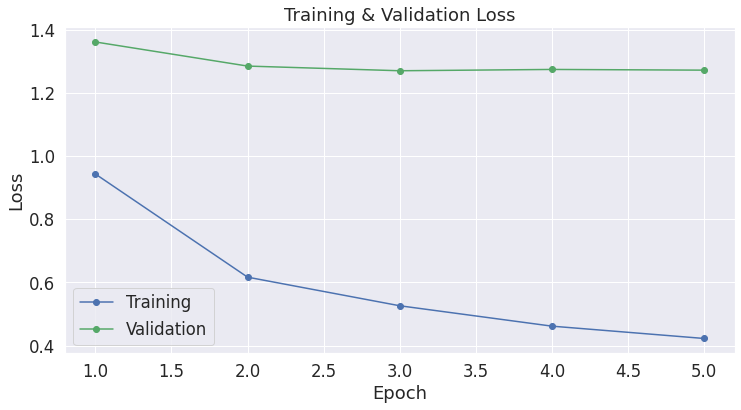

In [99]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Download the Data

In [102]:
#Transfer the Test Data in drive
used_test_df =pd.DataFrame(test_data)
used_test_df.to_csv(used_test_data_path, encoding='utf-8', index=False)
shutil.copy(used_test_data_path, '/content/drive/MyDrive/Complaints_csv/Experiment3/Test_data_DistilBERT.csv' )
print("\nTransfer Complete")


Transfer Complete


In [105]:
#Transfer the Encoded Tedt Data  in Drive 
encoded_test = pd.DataFrame(encoded_dataset['test'])
encoded_test.to_csv(encoded_test_data_path , encoding='utf-8', index=False)
shutil.copy(encoded_test_data_path  , '/content/drive/MyDrive/Complaints_csv/Experiment3/ENCODED_Test_data_DistilBERT.csv' )
print("\nTransfer Complete")


Transfer Complete


In [104]:
#Transfer the label2id_df in Drive 
label2id_df = pd.DataFrame([label2id] )
label2id_df.to_csv(label2id_df_path  , encoding='utf-8', index=False) 
shutil.copy(label2id_df_path , '/content/drive/MyDrive/Complaints_csv/Experiment3/label2id_df.csv' )
print("\nTransfer Complete")


Transfer Complete


In [103]:
#Transfer the best model in Drive 
shutil.copy(best_model_path, '/content/drive/MyDrive/Complaints_csv/Experiment3/best_model.pt' )
print("\nTransfer Complete")


Transfer Complete
